In [1]:
# Workaround to use src modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
# Library imports
import imageio
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters
from skimage.color import rgb2lab
from scipy.stats import mode

# Functions Imports
from src.utils import image_to_grayscale, image_minmax_norm
from src.quantization import image_bitshift
from src.segmentation import threshold_segmentation, otsu_segmentation
from src.visualizations import visualize_bitshift_images

### Objetivo

Explorar técnicas de extração de paleta de cores para redução da quantidade de cores necessárias na imagem final para um N pré-selecionado.

In [3]:
image_path = '../images/raw/anime_girl.png'
image = imageio.imread(image_path).astype(np.uint8)

In [4]:
# Pre-proccess - Change color to L*a*b color space
image_lab = rgb2lab(image[:,:,:3]).astype(int)
int_image_lab = image_lab.astype(int)

# Min pixel distance to palette
w_p = np.ones((image_lab.shape[0], image_lab.shape[1]), dtype=np.float32) * 1000.0

# Maping Lab coordinates into a single value to optimize Ocurrence calculations
disc_image_lab = np.zeros((image_lab.shape[0], image_lab.shape[1]), dtype=np.float32)
disc_image_lab[:,:] = (10**6)*(int_image_lab[:,:,2]+128.0) + (10**3)*(int_image_lab[:,:,1]+128.0) + (10**0)*(int_image_lab[:,:,0]+128.0)
disc_image_lab = disc_image_lab.astype(int)

In [5]:
def region_score(R, disc_R, w_p):
    
    # Average Minimum color distance weight
    w_p_avg = np.sum(np.power(w_p,2.0)) / float(R.size)
    
    # Average Lightness of the region
    L = np.sum(R[:,:,0]) / float(R.size)
    
    # Find color probabilities inside the region using a normalized histogram
    pc_r = []
    for i in range(R.shape[0]):
        for j in range(R.shape[1]):
            count = np.sum(disc_R == disc_R[i,j]) 
            pc_r.append(count/float(R.size))
    pc_r = np.array(pc_r)
    
    # Then use this probabilities to get the region entropy (Shannon)
    n_r = -np.sum(pc_r * np.log2(pc_r))
    
    # Compute the score and return
    S = n_r / (float(R.size) * w_p_avg * L)

    return S

In [6]:
palette = []
N = 8

Mx_scores = []
My_scores = []

for i in range(N):
    
    # Region Search -> Find the best Vertical and Horizontal Region
    Mx_scores = []
    My_scores = []
    
    print("Starting Mx Search...")
    for x in range(0, image_lab.shape[0], 3):
        Mx_scores.append(region_score(image_lab[x:x+3,:,:], disc_image_lab[x:x+3,:], w_p[x:x+3,:]))
    
    print("Starting My Search...")
    for y in range(0, image_lab.shape[1], 3):
        My_scores.append(region_score(image_lab[:,y:y+3,:], disc_image_lab[:,y:y+3], w_p[:,y:y+3]))
        
    ix, iy = (3*np.argmin(Mx_scores), 3*np.argmin(My_scores))
    print("Best Region:", ix, iy)
    
    # TODO: Try to increase region until find local minima
    print("Start local search...")
    top = left = right = bottom = True
    it  = il   = ir    = ib     = 0
    last_score = region_score(image_lab[ix:ix+3,iy:iy+3,:], disc_image_lab[ix:ix+3,iy:iy+3], w_p[ix:ix+3,iy:iy+3])
    
    while top or left or right or bottom:
        print("Border at", it, il, ir, ib)
        # Increase top
        if top and (ix-it-1) > 0:
            it   += 1
            score = region_score(image_lab[ix-it:ix+ib+3,iy-il:iy+ir+3,:], disc_image_lab[ix-it:ix+ib+3,iy-il:iy+ir+3], w_p[ix-it:ix+ib+3,iy-il:iy+ir+3])
            # Stop walking
            if score >= last_score:
                it -= 1
                top = False
            else:
                last_score = score
        else: top = False
                
        # Increase bottom
        if bottom and (ix+ib+1) < disc_image_lab.shape[0]-1:
            ib   += 1
            score = region_score(image_lab[ix-it:ix+ib+3,iy-il:iy+ir+3,:], disc_image_lab[ix-it:ix+ib+3,iy-il:iy+ir+3], w_p[ix-it:ix+ib+3,iy-il:iy+ir+3])
            # Stop walking
            if score >= last_score:
                ib -= 1
                bottom = False
            else:
                last_score = score
        else: bottom = False
                
        # Increase left
        if left and (iy-il-1) > 0:
            il   += 1
            score = region_score(image_lab[ix-it:ix+ib+3,iy-il:iy+ir+3,:], disc_image_lab[ix-it:ix+ib+3,iy-il:iy+ir+3], w_p[ix-it:ix+ib+3,iy-il:iy+ir+3])
            # Stop walking top
            if score >= last_score:
                il -= 1
                left = False
            else:
                last_score = score
        else: left = False
                
        # Increase right
        if right and (ix+ir+1) < disc_image_lab.shape[1]-1:
            ir   += 1
            score = region_score(image_lab[ix-it:ix+ib+3,iy-il:iy+ir+3,:], disc_image_lab[ix-it:ix+ib+3,iy-il:iy+ir+3], w_p[ix-it:ix+ib+3,iy-il:iy+ir+3])
            # Stop walking
            if score >= last_score:
                ir -= 1
                right = False
            else:
                last_score = score
        else: right = False
        

    # Color Extraction -> Get the color using the mode (most repetitive color)
    # Versão antiga :3
    # disc_color = mode(disc_image_lab[3*ix:3*ix+3,3*iy:3*iy+3].flatten())[0][0] 
    
    # Versão nova
    disc_color = mode(disc_image_lab[ix-it:ix+ib+3,iy-il:iy+ir+3].flatten())[0][0]
    
    lab_color  = [] 
    for i in range(3):
        lab_color.append((disc_color%(10**3))-128)
        disc_color = disc_color/(10**3)
    
    # Add Color to pallete and update min distances to pallete
    palette.append(np.array(lab_color))
    diff = np.power(image_lab-np.array(palette[-1]), 2.0)
    dist = np.sqrt(diff[:,:,0] + diff[:,:,1] + diff[:,:,2])
    w_p = np.where(w_p < dist, w_p, dist) 

Starting Mx Search...
Starting My Search...
Best Region: 561 567
Start local search...
Border at 0 0 0 0
Border at 0 1 1 1
Border at 0 2 2 1
Border at 0 3 2 1
Starting Mx Search...
Starting My Search...
Best Region: 270 564
Start local search...
Border at 0 0 0 0
Border at 1 1 1 1
Border at 2 1 2 2
Border at 3 1 3 3
Border at 4 1 3 4
Border at 5 1 3 5
Border at 6 1 3 6
Border at 6 1 3 7
Border at 6 1 3 8
Border at 6 1 3 9
Starting Mx Search...
Starting My Search...
Best Region: 270 567
Start local search...
Border at 0 0 0 0
Border at 1 1 0 1
Border at 2 2 0 2
Border at 3 2 0 3
Border at 4 2 0 4
Border at 5 2 0 5
Border at 6 2 0 6
Border at 6 2 0 7
Border at 6 2 0 8
Border at 6 2 0 9
Starting Mx Search...
Starting My Search...
Best Region: 270 567
Start local search...
Border at 0 0 0 0
Border at 1 1 0 1
Border at 2 2 0 2
Border at 3 2 0 3
Border at 4 2 0 4
Border at 5 2 0 5
Border at 6 2 0 6
Border at 6 2 0 7
Border at 6 2 0 8
Border at 6 2 0 9
Starting Mx Search...
Starting My Search

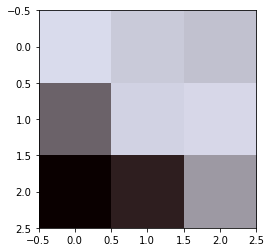

In [10]:
plt.imshow(image[561:561+3,567:567+3,:])

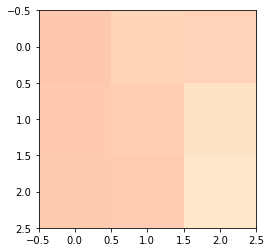

In [11]:
plt.imshow(image[270:270+3,564:564+3,:])

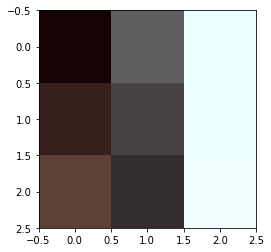

In [12]:
plt.imshow(image[270:270+3,567:567+3,:])

In [9]:
palette

[array([80.      ,  2.208   , -6.869792]),
 array([80.      , 14.208   , 20.142208]),
 array([88.      , -4.784   , -2.876784]),
 array([88.      , -4.784   , -2.876784]),
 array([88.      , -4.784   , -2.876784]),
 array([88.      , -4.784   , -2.876784]),
 array([88.      , -4.784   , -2.876784]),
 array([88.      , -4.784   , -2.876784])]